<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_ARIMAX_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis For Agritech Pest Prediction

## Model Implementation:

## **ARIMAX**

In [47]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [48]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [49]:
# Load datasets
FeatureExtracted_df = pd.read_csv('/content/FeatureExtracted_dataset.csv')

In [50]:
# Display basic info for  datasets FeatureExtracted_dataset
print(FeatureExtracted_df.head(), '\n')
print(FeatureExtracted_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
0                13.91      13.6       14.4             97.65  ...   
1                20.78      20.1       21.2             83.49  ...   
2                19.03      18.7       19.5             96.87  ...   
3                15.33      15.0       15.7             82.29  ...   
4                15.48      15.0       16.0             87.12  ...   

   Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
0          30.6             72.25      

In [51]:
# Convert 'Date' column to datetime format
FeatureExtracted_df['Date'] = pd.to_datetime(FeatureExtracted_df['Date'])

# Set Date column as index
FeatureExtracted_df.set_index('Date', inplace=True)

In [52]:
# Drop some columns
FeatureExtracted_df.drop(['Lag_1', 'Lag_1', 'Lag_1'], axis=1, inplace=True)

# Group and aggregate
aggregated_df = FeatureExtracted_df.groupby('Date').agg({
    'Number of Insects': 'sum',
    'New Catches': 'sum',
    'Event': 'max',
    'Average Temperature': 'mean',
    'Temp_low': 'mean',
    'Temp_high': 'mean',
    'Average Humidity': 'mean',
    'Day Avg_temp': 'mean',
    'Day Min_temp': 'mean',
    'Day Max_temp': 'mean',
    'Day Avg_Humidity': 'mean',
    'Temp_change': 'mean',
    'Year': 'first',
    'Month': 'first',
    'Day': 'first',
    'Weekday': 'first',
    # 'Lag_1': 'mean',
    # 'Lag_2': 'mean',
    # 'Lag_3': 'mean'
}).reset_index()

print(aggregated_df.head(10))

# # save to csv file
# aggregated_df.to_csv('aggregated_dataset.csv', index=False)

        Date  Number of Insects  New Catches  Event  Average Temperature  \
0 2024-07-05                0.0          0.0      0              16.6900   
1 2024-07-06                0.0          0.0      0              16.5225   
2 2024-07-07                0.0          0.0      0              19.8125   
3 2024-07-08                0.0          0.0      1              17.7825   
4 2024-07-09                0.0          0.0      1              18.4850   
5 2024-07-10                0.0          0.0      0              15.4800   
6 2024-07-11                0.0          0.0      1              15.8400   
7 2024-07-12                0.0          0.0      0              16.6350   
8 2024-07-13                0.0          0.0      0              18.9650   
9 2024-07-14                1.0          1.0      0              17.1300   

   Temp_low  Temp_high  Average Humidity  Day Avg_temp  Day Min_temp  \
0    16.300     17.000           89.4800       27.1400        15.700   
1    16.175     16.

In [53]:
# Convert "Date" to datetime format
aggregated_df["Date"] = pd.to_datetime(aggregated_df["Date"])

# Set "Date" as the index
aggregated_df.set_index("Date", inplace=True)

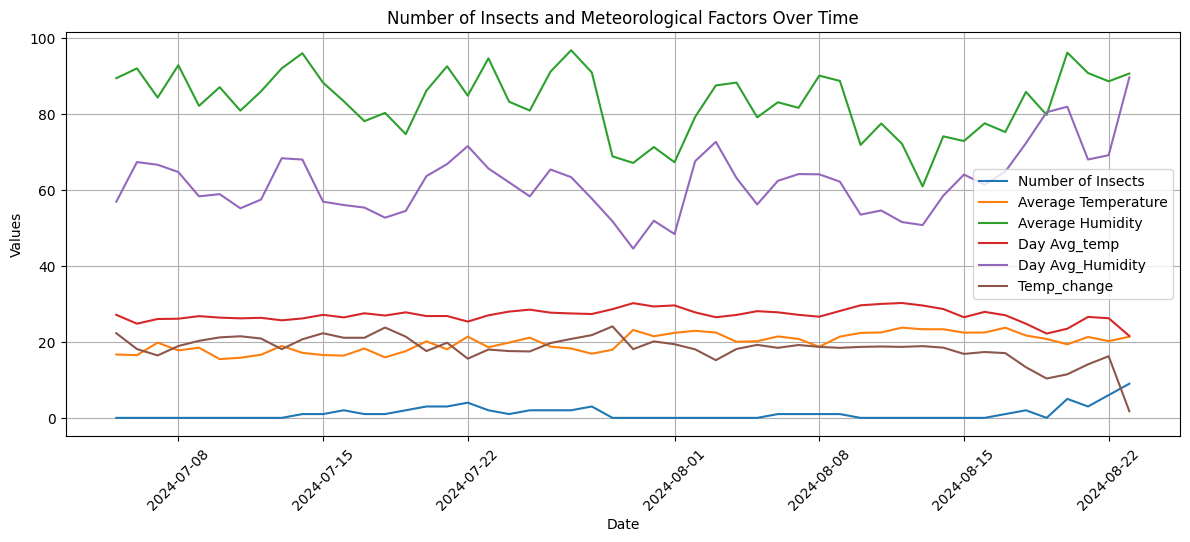

In [56]:
# Features to plot
features_to_plot = [
    'Number of Insects',
    'Average Temperature',
    'Average Humidity',
    'Day Avg_temp',
    'Day Avg_Humidity',
    'Temp_change'
]

# Plotting
plt.figure(figsize=(12, 5))
for feature in features_to_plot:
    plt.plot(aggregated_df.index, aggregated_df[feature], label=feature)

plt.title("Number of Insects and Meteorological Factors Over Time")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()